In [657]:
%pylab inline
import pandas as pd
import re
import os
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import spline
from sklearn.cross_decomposition import CCA
import sklearn.cross_decomposition

def interpolate(x,y):
    x_smooth = np.linspace(x.min(),x.max(),300) #300 represents number of points to make between T.min and T.max
    y_smooth = spline(x,y,x_smooth)
    return x_smooth,y_smooth

def gen_test_gmd(n_samples,n_bands):
    return 'kernprof -v -l CCA_calc_test.py {} {}'.format(n_samples,n_bands)

def run_tests(n_samples,n_bands):
    text = os.popen(gen_test_gmd(n_samples,n_bands)).read()
    
    return text

record_lines = {
    'calc_covariance' : ['calc_.._cov\(.*\)([^:]|\Z)'],
    'push' : ['push\(.*\)([^:]|\Z)'],
    'calc_ab' : ['calc_ab\(.*\)([^:]|\Z)'],
}

def parse_test_results(text):

    lines = text.split('\n')

    ret = dict()
    for k,v in record_lines.items():
        ret[k] = []
    
    time_unit = float(re.findall('Timer\sunit:\s([^\n]+)\s+s',text)[0])
    columns = ['Line #','Hits','Time','Per Hit','% Time']
    time_per_hit_column = columns.index('Per Hit')
    
    for line in lines:
        for k,v in record_lines.items():
            for pattern in v:
                if len( re.findall(pattern,line) ) > 0:
                    values = np.array([float(i) for i in line.split()[:len(columns)]])
                    ret[k].append(values[time_per_hit_column]*time_unit)
                    
    for k in ret.keys():
        ret[k] = np.min(ret[k])
        
        
    correlation = float(re.findall('correlation:\s([^\n]+)',text)[0])
    
    ret['cor'] = correlation
    
    return ret

Populating the interactive namespace from numpy and matplotlib


In [695]:
import CCA_calc
import time

def gen_samples(sample_size,n_bands=3):
    X = np.random.normal(0,1,size=(sample_size,n_bands))
    Y = X+np.random.normal(0,0.5,size=(sample_size,n_bands))
    return X,Y


sk_cca = sklearn.cross_decomposition.CCA(n_components=1)
def run_test_fast(n_samples,n_bands):
    cca =  CCA_calc.CCA(n_bands)
    times = []
    precision = []
    for i in range(5):
        X,Y = gen_samples(n_samples,n_bands)
        t_before = time.perf_counter()
        cca.push(X,Y)
        a,b = cca.calc_ab()
        t_after = time.perf_counter()
        
        corr_got = np.corrcoef( np.dot(X,np.ravel(a)), np.dot(Y,np.ravel(b)) )[0,1]
        
        sk_cca.fit(X,Y)
        X_new,Y_new = sk_cca.transform(X,Y)
        corr_true = np.corrcoef(np.ravel(X_new),np.ravel(Y_new),rowvar=False)[0,1]
        
        
        
        times.append(t_after-t_before)
        precision.append( corr_true-corr_got )
        
    results = {'total':np.median(times),'precision':np.mean(precision)}
    
    return results

# Run tests

In [703]:
# some caching
cache = dict()

def run_test(*args,fast=True):
    if fast:
        return run_test_fast(*args)
    else:
        text = '###\n'.join( [run_tests(*args) for i in range(2)] )
        results = parse_test_results(text)
        
def run_test_cached(*args):
    if args in cache:
        return cache[args]
    ret = run_test(*args)
    cache[args]=ret
    return ret

In [752]:
# results of profile CCA_calc.py

from collections import defaultdict

n_samples = (np.logspace(1,10,base=1.5,num=20)*5000).astype(np.int)
n_bands = np.array([2,8,12])

band_profile_n_samples = np.array( [100*100,50*50] )
band_profile_n_bands = np.array([2,4,6,8,12,14,18,20,22,24,26,28,30])#np.arange(2,13)

measures = defaultdict(lambda: defaultdict(list))
band_measures = defaultdict(lambda: defaultdict(list))

progress_max = len(n_samples)*len(n_bands)
for i,n in enumerate(n_samples):
    for j,n_b in enumerate(n_bands):
        progress = i*len(n_bands)+j+1
        if progress % 10 == 1 or progress == progress_max:
            print('running test for {} samples and {} bands ({} of {})'.format(n,n_b,progress,progress_max))
        results = run_test_cached(n,n_b)
        for k,v in results.items():
            measures[n_b][k].append(v)
         
        
progress_max = len(band_profile_n_samples)*len(band_profile_n_bands)
for i,n in enumerate(band_profile_n_samples):
    for j,n_b in enumerate(band_profile_n_bands):
        progress = (i*len(band_profile_n_bands))+j+1
        if progress % 5 == 1 or progress == progress_max:
            print('running test for {} samples and {} bands ({} of {})'.format(n,n_b,progress,progress_max))
        results = run_test_cached(n,n_b)
        for k,v in results.items():
            try:
                band_measures[n][k].append(v)
            except KeyError:
                band_measures[n] = band_measures.get(n,dict())
                band_measures[n][k] = []
        
for k,v in measures.items():
    for k2,v2 in v.items():
        measures[k][k2] = np.array(measures[k][k2])
        
for k,v in band_measures.items():
    for k2,v2 in v.items():
        band_measures[k][k2] = np.array(band_measures[k][k2])

running test for 7500 samples and 2 bands (1 of 60)


/usr/local/lib/python3.5/dist-packages/sklearn/cross_decomposition/pls_.py:83: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


running test for 13344 samples and 8 bands (11 of 60)
running test for 23742 samples and 12 bands (21 of 60)
running test for 51189 samples and 2 bands (31 of 60)
running test for 91077 samples and 8 bands (41 of 60)
running test for 162049 samples and 12 bands (51 of 60)
running test for 288325 samples and 12 bands (60 of 60)
running test for 10000 samples and 2 bands (1 of 26)
running test for 10000 samples and 14 bands (6 of 26)
running test for 10000 samples and 26 bands (11 of 26)
running test for 2500 samples and 6 bands (16 of 26)
running test for 2500 samples and 20 bands (21 of 26)
running test for 2500 samples and 30 bands (26 of 26)


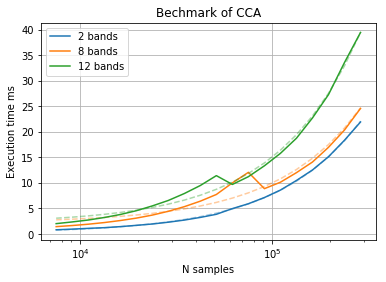

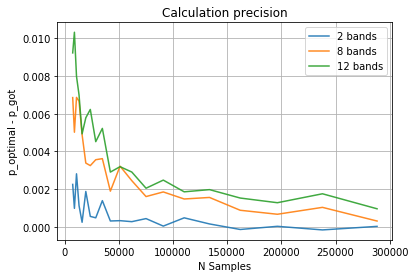

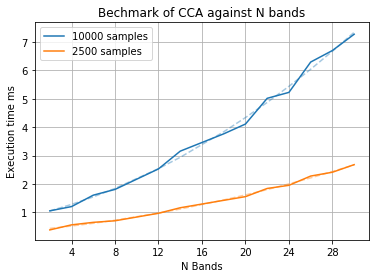

In [757]:
clfs = dict()

for i,band in enumerate( n_bands ):
    
    color = 'C{}'.format(i)
    label = '{} bands'.format(band) if band > 1 else '1 band'
    #plot(n_samples,measures['calc_covariance']*1e3,label='covariance');
    
    plot(n_samples,measures[band]['total']*1e3,'{}'.format(color),label=label);
#     plot(n_samples,measures[band]['precision'],color,label=label)

    # plot fitting line
    clf = linear_model.Ridge()
    clf.fit(n_samples[:,np.newaxis],measures[band]['total']*1e6)
    plot(n_samples,clf.predict(n_samples[:,np.newaxis])/1e3,'{}--'.format(color),alpha=0.4 );
    clfs[band] = clf
    
    
grid(True)
title('Bechmark of CCA')
xscale('log')
ylabel('Execution time ms')
xlabel('N samples')
legend()
show()

for i,band in enumerate( n_bands ):
    
    color = 'C{}'.format(i)
    label = '{} bands'.format(band) if band > 1 else '1 band'
    plot(n_samples,measures[band]['precision'],color,label=label,alpha=0.9)
    
grid(True)
legend()
title('Calculation precision')
ylabel('p_optimal - p_got')
xlabel('N Samples')
show()

for i,n in enumerate( band_profile_n_samples ):
    
    color = 'C{}'.format(i)
    label = '{} samples'.format(n)
    
    plot(band_profile_n_bands,band_measures[n]['total']*1e3,color,label=label);
    
    
    clf = linear_model.Ridge()
    
    bands_x = band_profile_n_bands[:,np.newaxis]
    new_x = np.concatenate((bands_x,bands_x*bands_x),axis=1)
    clf.fit(new_x,band_measures[n]['total']*1e6)
    plot(band_profile_n_bands,clf.predict(new_x)/1e3,'{}--'.format(color),alpha=0.4 );

    
#ax = plt.figure().gca()
axes().xaxis.set_major_locator(MaxNLocator(integer=True))
grid(True)
legend()
title('Bechmark of CCA against N bands')
ylabel('Execution time ms')
xlabel('N Bands')
show();
        
#print('T(N) = {:.3f} + {:.0f} N [ns]'.format(clf.coef_[0],clf.intercept_))
#plot(n_samples,measures['calc_ab']*1e3,label='a,b');

In [408]:
def print_calc_time(x_size,y_size,postfix=''):
    megapixels = x_size*y_size/1e6
    n_bands = 8
    print('{: >6} x{: >6} {} bands ({: >6.2f} MPix): {:.0f} ms {}'.format(x_size,y_size,n_bands,megapixels,clfs[n_bands].predict([[x_size*y_size]])[0]/1e3,postfix))
    
print_calc_time(1024,1024)
print_calc_time(4000,4000)
print_calc_time(6100,6100,'(Landsat 8)')
print_calc_time(12000,12000)

  1024 x  1024 8 bands (  1.05 MPix): 95 ms 
  4000 x  4000 8 bands ( 16.00 MPix): 1432 ms 
  6100 x  6100 8 bands ( 37.21 MPix): 3328 ms (Landsat 8)
 12000 x 12000 8 bands (144.00 MPix): 12877 ms 


In [286]:
clf.coef_

array([ 84.45363743])

In [287]:
clf.intercept_

291169.87448972277

In [261]:
from sklearn import linear_model

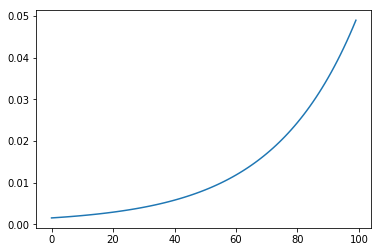

In [267]:
clf = linear_model.Ridge()
clf.fit(n_samples[:,np.newaxis],measures['push'])
plot( clf.predict(n_samples[:,np.newaxis]) )

# Write results into dataframe

In [223]:
column_names = list(measures.keys())
data = [i for i in zip(n_samples,*(measures[i] for i in column_names))]
data = pd.DataFrame(data,columns=['N samples',*column_names])
data

,N samples,calc_covariance,calc_ab,push
0,7500,0.000015,0.000338,0.000863
1,9088,0.000016,0.000463,0.001032
2,11012,0.000016,0.000337,0.001230
3,13344,0.000015,0.000321,0.001456
4,16169,0.000015,0.000305,0.001760
5,19593,0.000016,0.000388,0.002172
6,23742,0.000017,0.000335,0.002510
7,28770,0.000016,0.000310,0.003038
8,34862,0.000017,0.000346,0.003517
9,42244,0.000017,0.000371,0.004044


In [232]:
print(text)

Number of samples is: 288325
a:
[[ 0.00107359]
 [ 0.82623166]
 [ 0.99011485]]
b:
[[-0.26508857]
 [ 0.48718532]
 [-0.14951347]]
Wrote profile results to CCA_calc_test.py.lprof
Timer unit: 1e-06 s

Total time: 0.223966 s
File: CCA_calc_test.py
Function: push at line 23

Line #      Hits         Time  Per Hit   % Time  Line Contents
    23                                           	@profile
    24                                           	def push(self,x,y):
    25                                           		"""
    26                                           		push x and y to caclulate cca. x and y values are not stored
    27                                           		"""
    28        10        61593   6159.3     27.5  		self.x_sum += np.sum(x,axis=0)[:,np.newaxis]
    29        10        58992   5899.2     26.3  		self.y_sum += np.sum(y,axis=0)[:,np.newaxis]
    30        10        35562   3556.2     15.9  		self.xy_sum += np.matmul(np.transpose(x),y)
    31        10        33829 